# Forward Modeling of an Emission Spectrum using the DIT Cross Section

In [1]:
from exojax.spec import rtransfer as rt
from exojax.spec import dit
from exojax.spec import lpf
import numpy as np

In [2]:
#ATMOSPHERE                                                                     
NP=100
T0=1295.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

A T-P profile we assume is ...  

In [3]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.plot(Tarr,Parr)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

<Figure size 640x480 with 1 Axes>

We set a wavenumber grid using nugrid.

In [4]:
from exojax.spec.rtransfer import nugrid
nus,wav,res=nugrid(22900,23000,10000,unit="AA",xsmode="dit")

nugrid is linear: mode= dit


Loading a molecular database of CO and CIA (H2-H2)... 

In [5]:
from exojax.spec import moldb, contdb
mdbCO=moldb.MdbExomol('.database/CO/12C-16O/Li2015',nus)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states
H2-H2


In [6]:
from exojax.spec import molinfo
molmassCO=molinfo.molmass("CO")

Computing the relative partition function, 

In [7]:
from jax import vmap
qt=vmap(mdbCO.qr_interp)(Tarr)

Pressure and Natural broadenings 

In [8]:
from jax import jit
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural

gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCO.n_Texp,mdbCO.alpha_ref)
gammaLMN=gamma_natural(mdbCO.A)
gammaLM=gammaLMP+gammaLMN[None,:]

Doppler broadening

In [9]:
from exojax.spec import doppler_sigma
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
        (mdbCO.nu_lines,Tarr,molmassCO)

And line strength

In [10]:
from exojax.spec import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)

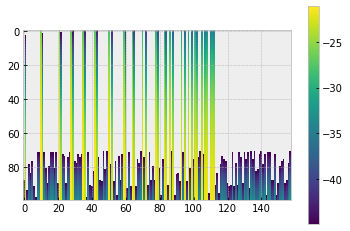

In [11]:
import jax.numpy as jnp
c=plt.imshow(jnp.log10(SijM))
plt.colorbar(c)

In [12]:
#direct LPF for comparison
from exojax.spec import make_numatrix0
from exojax.spec.lpf import xsmatrix
numatrix=make_numatrix0(nus,mdbCO.nu_lines)
xsmdirect=xsmatrix(numatrix,sigmaDM,gammaLM,SijM)

DIT

In [13]:
dgm_sigmaD=dit.dgmatrix(sigmaDM,res=0.1)
dgm_gammaL=dit.dgmatrix(gammaLM,res=0.2)

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


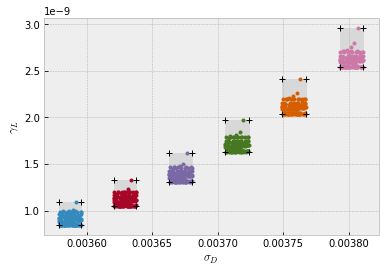

In [14]:
#show the DIT grids 
from exojax.plot.ditplot import plot_dgm
plot_dgm(dgm_sigmaD,dgm_gammaL,sigmaDM,gammaLM,0,6)

xsmatrix has the shape of (# of layers, # of nu grid)

In [17]:
#check adequate Nfold
mdgm_gammaL=jnp.min(dgm_gammaL,axis=1)
mdgm_sigmaD=jnp.min(dgm_sigmaD,axis=1)
sigma=jnp.min(0.5*mdgm_gammaL+jnp.sqrt(0.25*mdgm_gammaL**2+mdgm_sigmaD**2))
dnu=nus[1]-nus[0]
relres,Nfold=dit.autoNfold(sigma,dnu,1.5)
print(Nfold)

1


In [19]:
#here we use the precomputed NCF for wavenumber

dLarray=dit.make_dLarray(Nfold,dnu)
nu_ncf=dit.npnc1D(mdbCO.nu_lines,nus)
xsmdit=dit.xsmatrix(nu_ncf,sigmaDM,gammaLM,SijM,nus,dgm_sigmaD,dgm_gammaL,dLarray)

100%|██████████| 10000/10000 [00:00<00:00, 123682.37it/s]


In [21]:
# or 3D version
xsmdit3D=dit.xsmatrix3D(mdbCO.nu_lines-np.median(nus),sigmaDM,gammaLM,\
SijM,nus-np.median(nus),dgm_sigmaD,dgm_gammaL,dLarray)

/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


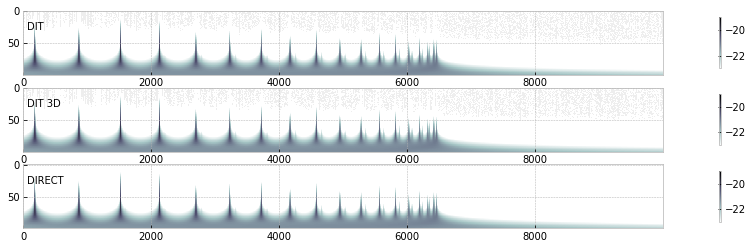

In [22]:
import numpy as np
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(311)
c=plt.imshow(np.log10(xsmdit),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIT")
ax.set_aspect(0.1/ax.get_data_ratio())
ax=fig.add_subplot(312)
c=plt.imshow(np.log10(xsmdit3D),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIT 3D")
ax.set_aspect(0.1/ax.get_data_ratio())
ax=fig.add_subplot(313)
c=plt.imshow(np.log10(xsmdirect),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIRECT")
ax.set_aspect(0.1/ax.get_data_ratio())
plt.show()

computing delta tau for CO

In [23]:
from exojax.spec.rtransfer import dtauM
Rp=0.88
Mp=33.2
g=2478.57730044555*Mp/Rp**2
#g=1.e5 #gravity cm/s2
MMR=0.0059 #mass mixing ratio
dtaum=dtauM(dParr,xsmdit,MMR*np.ones_like(Tarr),molmassCO,g)
dtaum3D=dtauM(dParr,xsmdit3D,MMR*np.ones_like(Tarr),molmassCO,g)

In [24]:
dtaumdirect=dtauM(dParr,xsmdirect,MMR*np.ones_like(Tarr),molmassCO,g)

computing delta tau for CIA

In [25]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [26]:
dtau=dtaum+dtaucH2H2
dtau3D=dtaum3D+dtaucH2H2
dtaudirect=dtaumdirect+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

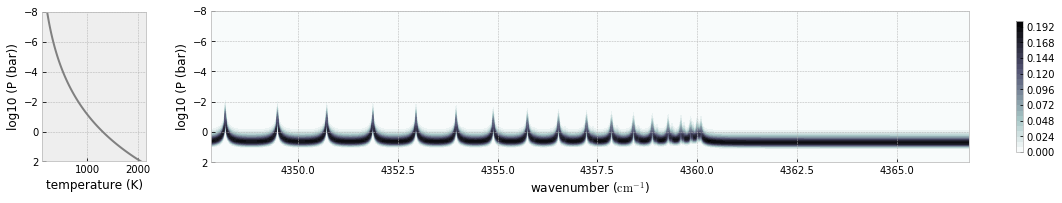

In [27]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [28]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)
F03D=rtrun(dtau3D,sourcef)
F0direct=rtrun(dtaudirect,sourcef)

Text(0.5, 0, 'wavelength ($\\AA$)')

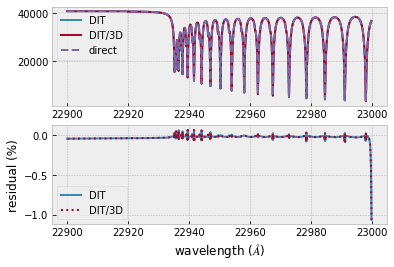

In [29]:
fig=plt.figure()
ax=fig.add_subplot(211)
plt.plot(wav[::-1],F0,label="DIT")
plt.plot(wav[::-1],F03D,label="DIT/3D")
plt.plot(wav[::-1],F0direct,ls="dashed",label="direct")
plt.legend()
ax=fig.add_subplot(212)
plt.plot(wav[::-1],(F0-F0direct)/np.median(F0direct)*100,label="DIT")
plt.plot(wav[::-1],(F03D-F0direct)/np.median(F0direct)*100,label="DIT/3D",ls="dotted")
plt.legend()
plt.ylabel("residual (%)")
plt.xlabel("wavelength ($\AA$)")

To apply response, we need to convert the wavenumber grid from ESLIN to ESLOG. 

In [30]:
nuslog=np.logspace(np.log10(nus[0]),np.log10(nus[-1]),len(nus))
F0log=jnp.interp(nuslog,nus,F0)

applying an instrumental response and planet/stellar rotation to the raw spectrum

In [31]:
from exojax.spec import response
from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(22920,23000,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

Frot=response.rigidrot(nuslog,F0log,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nuslog,Frot,beta,RV)

(22920, 23000)

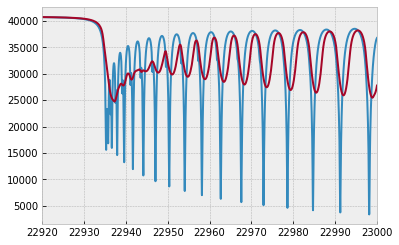

In [32]:
plt.plot(wav[::-1],F0)
plt.plot(wavd[::-1],F)
plt.xlim(22920,23000)